# Tutorial-2: Integrating RNA+ADT+ATAC Single-Cell Data Using MIDAS
In this tutorial, we demonstrate how to use MIDAS for integrating more complicated multi-modal mosaic single-cell data (DOGMA) across different batches.

## Data Downloading & Pre-processing
We offer pre-processed data that you can download from link https://drive.google.com/drive/folders/1j3hDl2p4v3s0r5a-ktfHqbIhHbIPpUbS?usp=drive_link to save time. Meanwhile, labels are provided as well. However, if processing from raw data is preferred, follow these steps:

Download Data: Fetch the data from the URL provided (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE166188).

Organize Data: Place the downloaded data into the directory "data/raw/atac+rna+adt/dogma" and format the files as :
```
.
└── data/raw/atac+rna+adt
    └── dogma
        ├── dig_ctrl
        │   ├── GSM5065530_DIG_CTRL_fragments.tsv.gz
        │   ├── ...
        ├── dig_stim
        │   ├── GSM5065533_DIG_STIM_fragments.tsv.gz
        │   ├── ...
        ├── lll_ctrl
        │   ├── GSM5065524_LLL_CTRL_fragments.tsv.gz
        │   ├── ...
        └── lll_stim
            ├── GSM5065527_LLL_STIM_fragments.tsv.gz
            ├── ...
            └── GSM5065529_LLL_stim_ADT_allCounts.proteins.txt.gz
```

Automate Processing: Run scripts to process the data, which typically involves loading it into a suitable data structure or format for further analysis.

In [1]:
# Rscript preprocess/atac+rna+adt_dogma_lll_ctrl.R
# Rscript preprocess/atac+rna+adt_dogma_lll_stim.R
# Rscript preprocess/atac+rna+adt_dogma_dig_ctrl.R

In [2]:
# Rscript preprocess/combine_subsets.R --task dogma_demo_offline && python preprocess/split_mat.py --task dogma_demo_offline

## Integrating with MIDAS

In [1]:
from scmidas.models import MIDAS
from scmidas.datasets import GetDataInfo
import scanpy as sc
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Initializing Model
We manually set "mods" to define a combination of modalities. If "mods" is not specified, all available modalities will be used for training.

In [2]:
task = "dogma_demo_offline"
mods = {"subset_0":["rna", "adt"], "subset_1":["atac", "rna"], "subset_2":["atac", "adt"]}
data = [GetDataInfo(f'./data/processed/{task}', mods=mods)]  # Support integration of multiple GetDataInfo objects with different features.

3 subset(s) in this path {'atac': 30521, 'rna': 4054, 'adt': 208}
  subset_0 :  7361 cells ; ['rna', 'adt']
  subset_1 :  5897 cells ; ['atac', 'rna']
  subset_2 : 10190 cells ; ['atac', 'adt']


### Training
The function .init_model can accept parameters for customizing the model structure. Here, we utilize the default model structure.

In [3]:
model = MIDAS(data)
model.init_model()
model.train(n_epoch=500, save_path=f'./result/{task}/train/')

Parameter number: 18.562 M
Training ...


Loss: 8475.4664: 100%|██████████| 500/500 [3:43:31<00:00, 26.82s/it]  


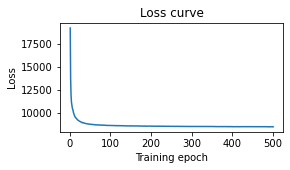

In [4]:
model.viz_loss()

### Inference
We support predicting various types of outputs, including embeddings and corrected counts. Here, we demonstrate how to retrieve embeddings.

In [5]:
model.predict(save_dir=f'./result/{task}/predict/', mod_latent=False)

Predicting ...
Removing directory "./result/dogma_demo_offline/predict/subset_1/z"
Removing directory "./result/dogma_demo_offline/predict/subset_0/z"


  0%|          | 0/29 [00:00<?, ?it/s]

Processing subset 0: ['rna', 'adt']


  0%|          | 0/24 [00:00<?, ?it/s]

Processing subset 1: ['atac', 'rna']


  0%|          | 0/40 [00:00<?, ?it/s]

Processing subset 2: ['atac', 'adt']


100%|██████████| 40/40 [00:08<00:00,  4.51it/s]


In [6]:
emb = model.read_embeddings()

  0%|          | 0/40 [00:00<?, ?it/s]

Loading predicted variables ...
Loading subset 0: z, joint
Loading subset 1: z, joint
Loading subset 2: z, joint


100%|██████████| 40/40 [00:00<00:00, 309.42it/s]


Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: z, joint
Converting subset 1: s, joint
Converting subset 1: z, joint
Converting subset 2: s, joint
Converting subset 2: z, joint


### Visualization

In [2]:
import os
os.chdir("/opt/data/private/zjh/midasv2/")

In [3]:
task = "dogma_demo_offline"
mods = {"subset_0":["rna", "adt"], "subset_1":["atac", "rna"], "subset_2":["atac", "adt"]}
data = [GetDataInfo(f'./data/processed/{task}', mods=mods)]  # Support integration of multiple GetDataInfo objects with different features.
model = MIDAS(data)
model.init_model(model_path = f"/opt/data/private/zjh/midasv2/result/{task}/train/sp_latest.pt")
emb = model.read_embeddings(emb_path=f"/opt/data/private/zjh/midasv2/result/{task}/predict")

3 subset(s) in this path {'atac': 30521, 'rna': 4054, 'adt': 208}
  subset_0 :  7361 cells ; ['rna', 'adt']
  subset_1 :  5897 cells ; ['atac', 'rna']
  subset_2 : 10190 cells ; ['atac', 'adt']
load a pretrained model from /opt/data/private/zjh/midasv2/result/dogma_demo_offline/train/sp_latest.pt
Parameter number: 18.562 M
Loading predicted variables ...
Loading subset 0: z, joint


100%|██████████| 29/29 [00:00<00:00, 170.46it/s]


Loading subset 1: z, joint


100%|██████████| 24/24 [00:00<00:00, 174.13it/s]


Loading subset 2: z, joint


100%|██████████| 40/40 [00:00<00:00, 87.88it/s] 


Converting to numpy ...
Converting subset 0: s, joint
Converting subset 0: z, joint
Converting subset 1: s, joint
Converting subset 1: z, joint
Converting subset 2: s, joint
Converting subset 2: z, joint


/root/anaconda3/envs/scmidas/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/anaconda3/envs/scmidas/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/anaconda3/envs/scmidas/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/anaconda3/envs/scmidas/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


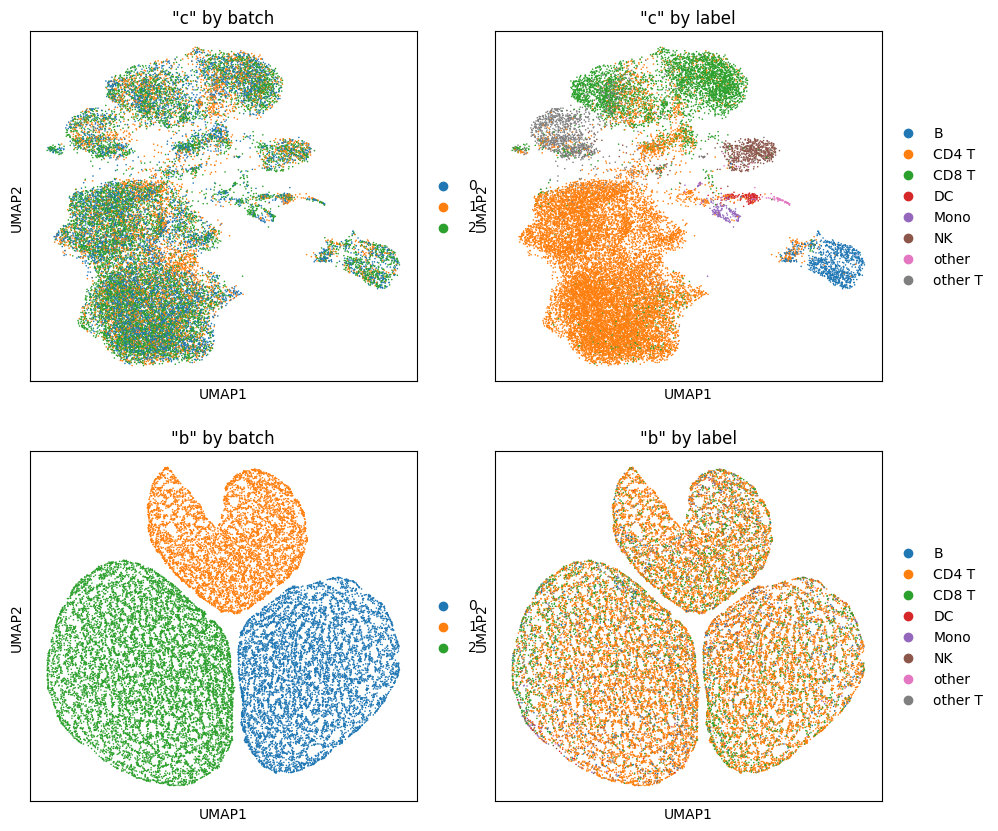

In [7]:
c = emb["z"]["joint"][:, :32]
b = emb["z"]["joint"][:, 32:]
adata = sc.AnnData(c)
adata2 = sc.AnnData(b)
adata.obs['batch'] = emb["s"]["joint"].astype('str')
adata2.obs['batch'] = emb["s"]["joint"].astype('str')

label = pd.concat([pd.read_csv(f'./data/raw/atac+rna+adt/dogma/lll_ctrl/label_seurat/l1.csv', index_col=0),
                   pd.read_csv(f'./data/raw/atac+rna+adt/dogma/lll_stim/label_seurat/l1.csv', index_col=0),
                   pd.read_csv(f'./data/raw/atac+rna+adt/dogma/dig_ctrl/label_seurat/l1.csv', index_col=0),
                   ])
adata.obs['label'] = label.values.flatten()
adata2.obs['label'] = label.values.flatten()
sc.pp.subsample(adata, fraction=1)
sc.pp.subsample(adata2, fraction=1)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
f, ax = plt.subplots(2,2,figsize=[11, 10])
sc.pl.umap(adata, color='batch', title='"c" by batch', ax=ax[0, 0], show=False)
sc.pl.umap(adata, color='label', title='"c" by label', ax=ax[0, 1], show=False)
sc.pl.umap(adata2, color='batch', title='"b" by batch' , ax=ax[1, 0], show=False)
sc.pl.umap(adata2, color='label', title='"b" by label' , ax=ax[1, 1], show=False)
plt.show()